### S&P Cliques

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, requests
from time import sleep
from IPython.display import display

1. Скачать с сайта finance.yahoo.com перечень ценных бумаг входящих в индекс Доу Джонса (искать ^DJI), S&P 500 (^GSPC). Чтобы загрузить таблицу с этого сайта надо сделать вид, что мы браузер

In [2]:
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
request = requests.get('https://www.slickcharts.com/sp500', headers=header)
gspc_df = pd.read_html(request.text)[0]

In [3]:
ticker_gspc=gspc_df['Symbol'].values[:-1] # данных по последнему наблюдению нет
ticker_gspc[3], ticker_gspc[449] = 'BRK-B', 'BF-B' # расхождения в обозначениях

2. Загрузить цену закрытия за 2018 год. Поскольку  на YAHOO Finance есть ограничение на скачивние установим время ожидания между скачиваниями

```python
start=datetime.datetime(2018,1,1)
finish=datetime.datetime(2018,12,31)

gspc_close={ }

for i in ticker_gspc:
    gspc_close[i]=web.DataReader(i, 'yahoo', start, finish)['Close']
    sleep(30) 

gspc_close = pd.DataFrame(gspc_close)

```

- Поскольку это долго, подгрузим уже скачанный файл 

In [4]:
gspc_close = pd.read_csv('gspc_close.csv', index_col = 0, parse_dates = True)

3. Построить ряды изменения процентов закрытия: используя процентые соотношения, мы лучше отследим динамику рядов  относительно друг друга, поскольку средние цены для акций разых компаний сильно разнятся и при построении оригинальных временных рядов ряды будут расположены на разных уровнях:

In [5]:
gspc_pct=(gspc_close/gspc_close.shift(1)-1).fillna(0)

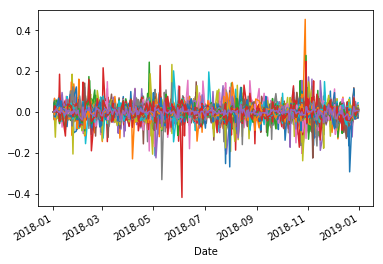

In [6]:
gspc_pct.plot(legend = False);

4. Построить взаимно-корреляционную матрицу для ценных бумаг за данный период для ряда:

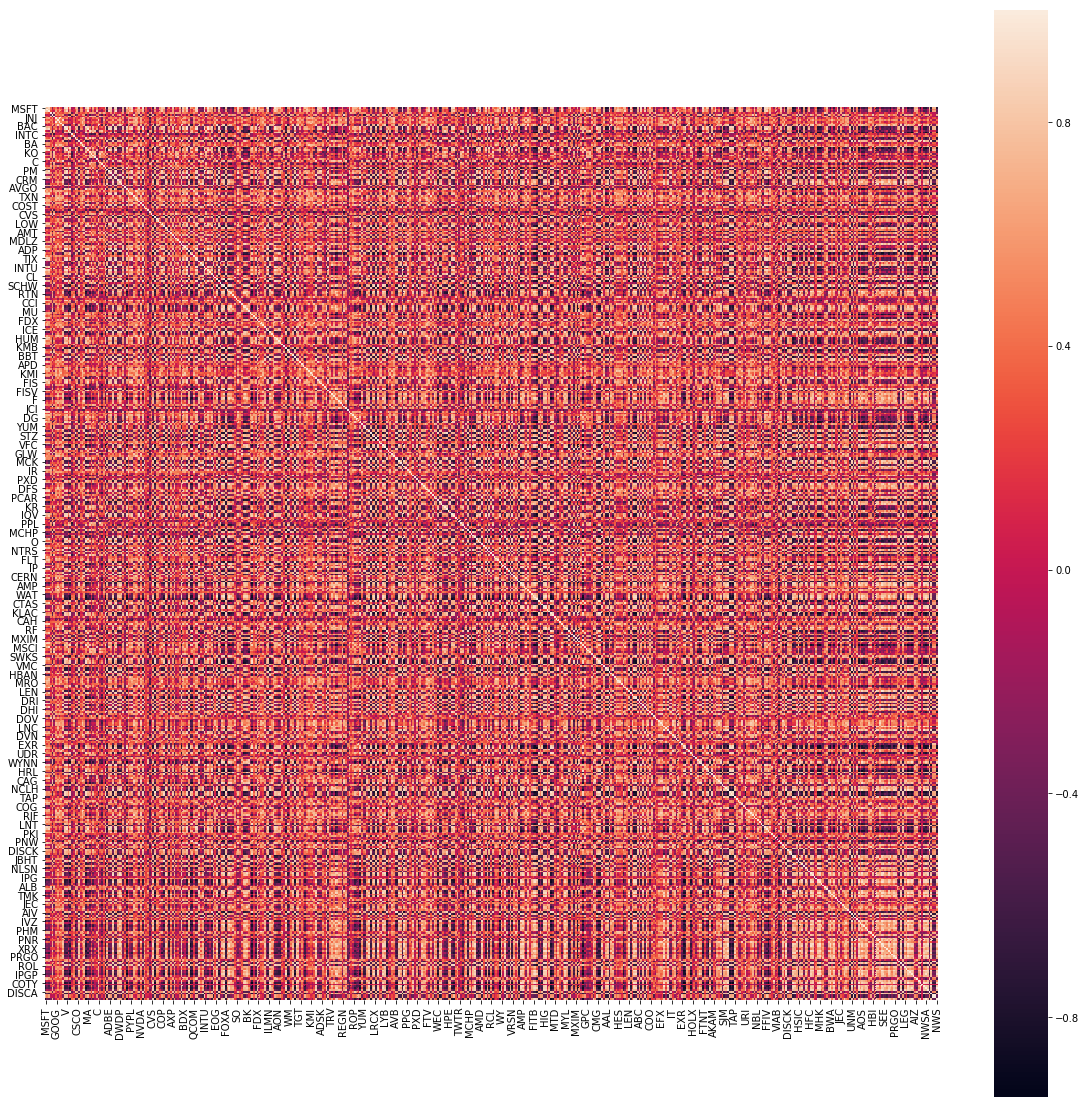

In [7]:
plt.figure(figsize = (20,20))
sns.heatmap(gspc_close.corr(), square = True);

5. Выбрать порог высокой взаимной корреляции, пусть будет 0.8 и заменить значения в матрице на 1 более 0.8 и на 0 менее 0.8 

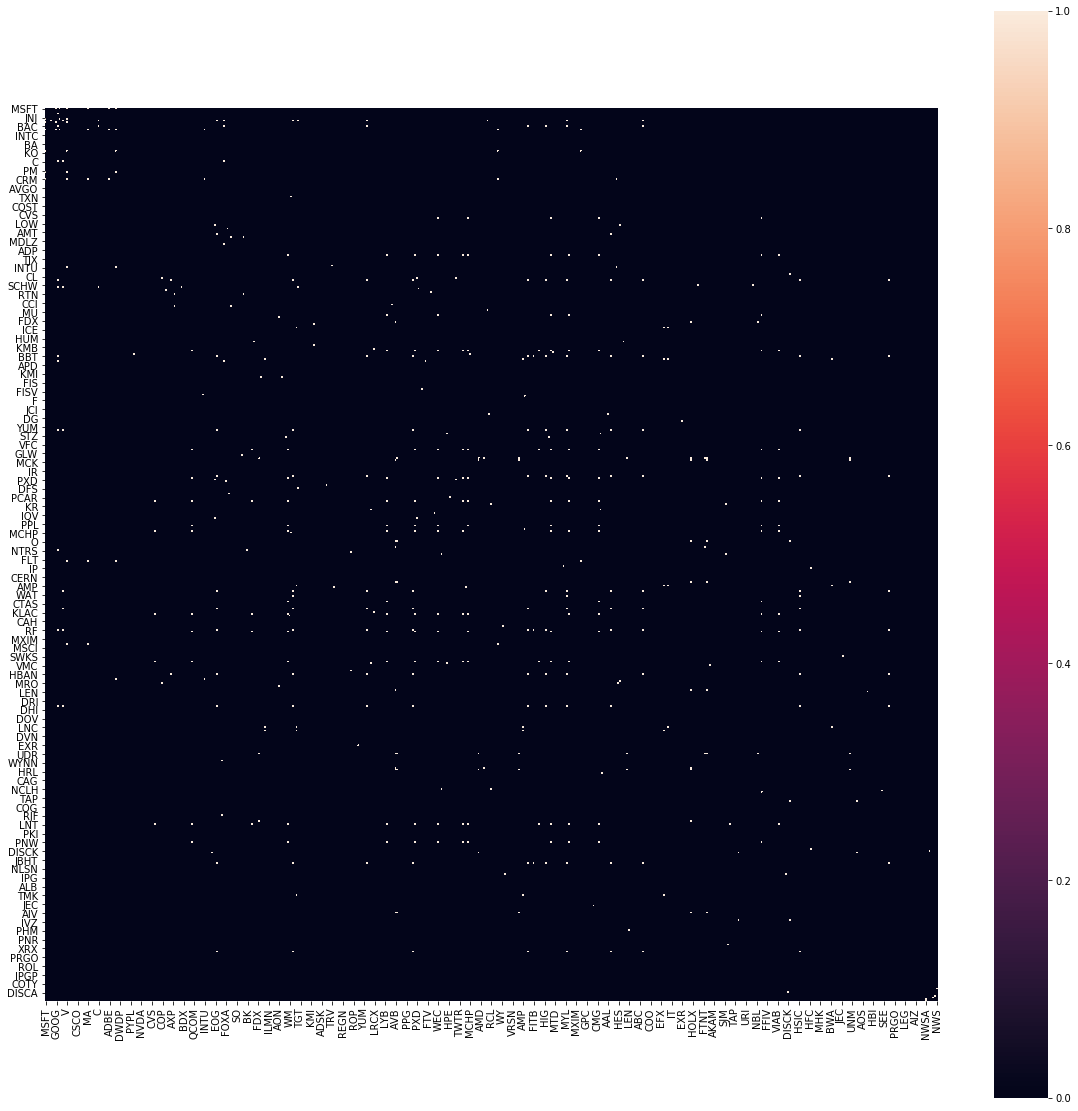

In [8]:
plt.figure(figsize = (20,20))
gscp_pct_graph=(abs(gspc_pct.corr().replace(1,0))>0.8).astype(int)
sns.heatmap(gscp_pct_graph, square = True);

6. Построить граф - пакет networkx 

/home/xenakas/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


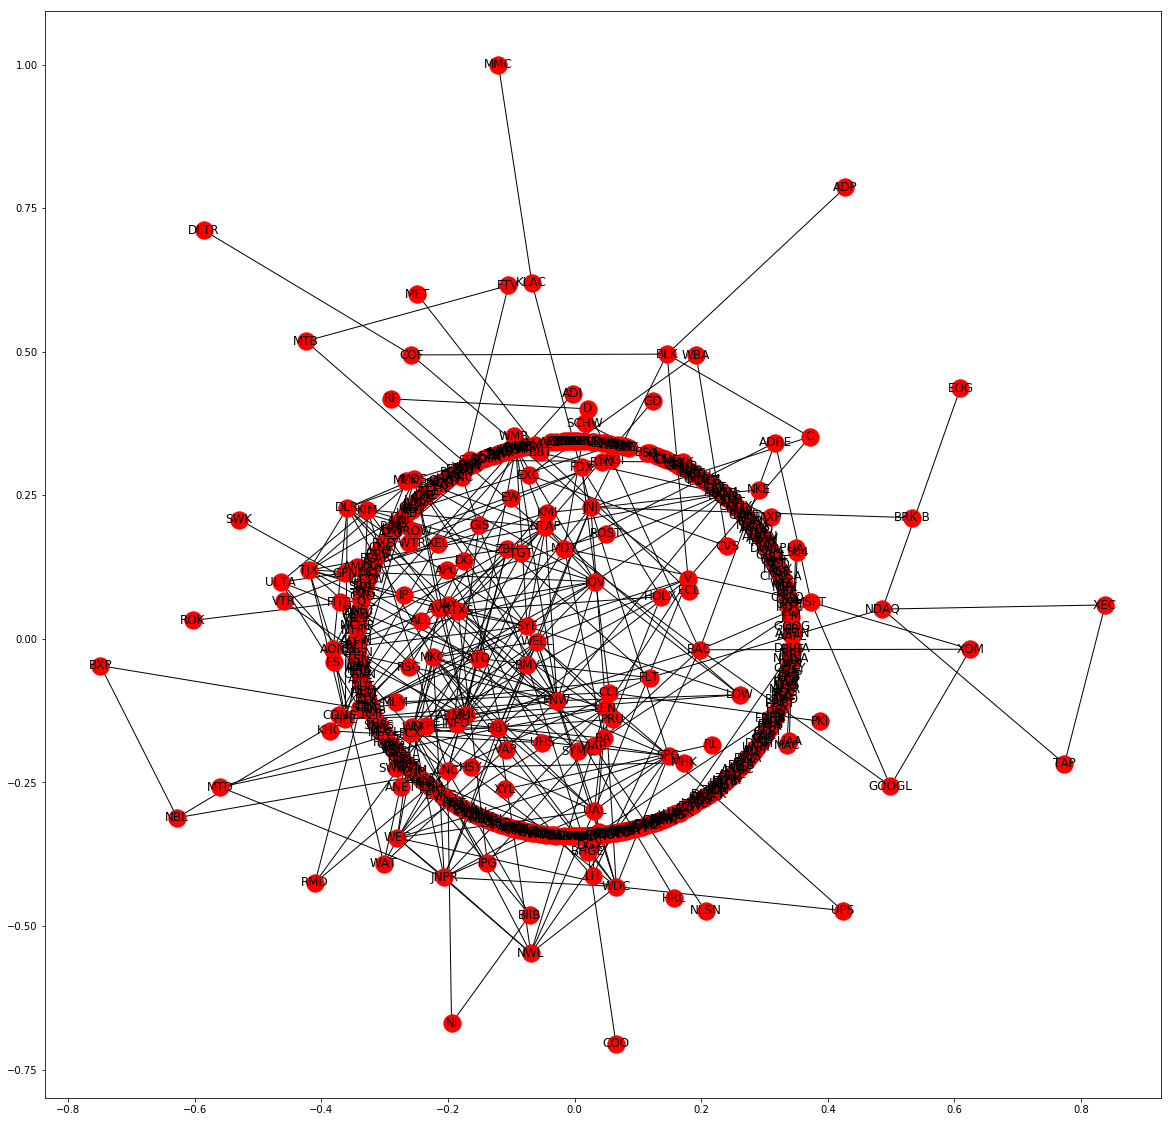

In [9]:
plt.figure(figsize = (20,20))
m=gscp_pct_graph.values
n=ticker_gspc
G=nx.from_numpy_matrix(m)
G=nx.relabel_nodes(G, dict(zip(G.nodes(),n)))
nx.draw_networkx(G, pos= nx.kamada_kawai_layout(G));

7. Найти клики на графе, найти максимальную клику. 

In [10]:
cliques=list(nx.find_cliques(G)) 
lengths = []
lengths = [len(i) for i in cliques]
longest_ind = [i for i, j in enumerate(lengths) if j == max(lengths)]
cliq_list = [cliques[i] for i in longest_ind] # Клики различаются только 'ES' и 'ETR', поэтому сделаем из двух клик (11 элементов) одну (12 элементов)
cliq_list[0].append(cliq_list[1][-1])
cliq_list = cliq_list[0]

In [11]:
gspc_df[gspc_df['Symbol'].isin(cliq_list)][['Company', 'Symbol']]

,Company,Symbol
83,TJX Companies Inc,TJX
137,Aon plc,AON
193,AvalonBay Communities Inc.,AVB
209,Digital Realty Trust Inc.,DLR
222,IQVIA Holdings Inc,IQV
236,Hewlett Packard Enterprise Co.,HPE
239,Synchrony Financial,SYF
286,NetApp Inc.,NTAP
296,Church & Dwight Co. Inc.,CHD
313,Vulcan Materials Company,VMC


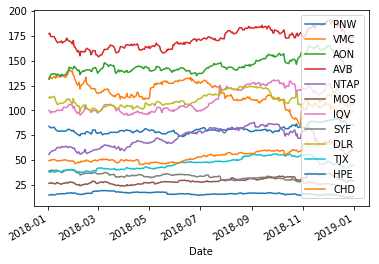

In [12]:
cliq_close = gspc_close[cliq_list]
cliq_close.plot();

На графике видно, что движения цен закрытия у всех акций синхронные, к тому же все 12 компаний из клики являются энергетическими компаниями

8. Визуализировать кумулятивную процентную доходность для максимальной клики. 

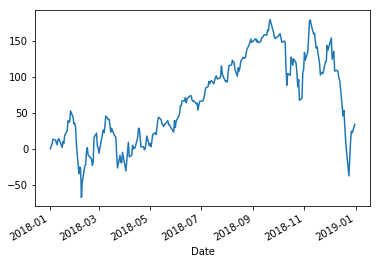

In [13]:
cum_sum=((cliq_close/cliq_close.shift(1)-1).fillna(0)*100).cumsum()
cum_sum.sum(axis=1).plot();

9. Визуализировать риск для клики (мат. ожидание процентного дохода (ежедневного) на периоде к СКО на периоде). 

Квадратический коэффициент вариации:
$$v = \frac{\sigma}{\bar{X}}$$

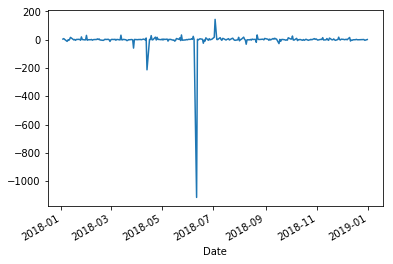

In [14]:
pd.DataFrame((cliq_close/cliq_close.shift(1)-1).fillna(0).std(axis=1)/(cliq_close/cliq_close.shift(1)-1).fillna(0).mean(axis=1)).plot(legend = False)

#### [Exploring the best possible trade-off between competing objectives: identifying the Pareto Front](https://pythonhealthcare.org/tag/pareto-front/)

https://sirinnes.wordpress.com/2013/04/25/pareto-frontier-graphic-via-python/

In [27]:
means = gspc_pct.mean(axis=0).values
stds = gspc_pct.std(axis=0).values

In [28]:
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y)
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.show()


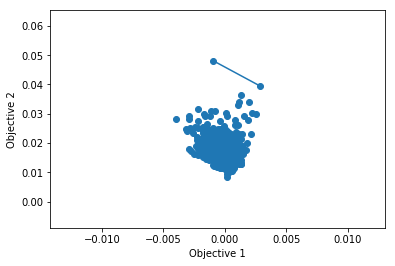

In [29]:
plot_pareto_frontier(means, stds)